In [307]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc, recall_score
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import yfinance as yf
import matplotlib.pyplot as plt

import datetime as dt
from alive_progress import alive_bar
0
import warnings
warnings.filterwarnings(action='ignore')

In [308]:
def get_stock_data(ticker: str, period: str) -> pd.DataFrame:
    '''
    ticker: str - the stock ticker to get data for
    returns: pd.DataFrame - the stock data for the given ticker
    '''
    
    # check if a new day has started
    if os.path.exists(f'data/{ticker}.json'):
        now = dt.datetime.now()
        if now.hour < 9:
            print('Reading from Cache')
            return pd.read_json(f'data/{ticker}.json')
    else:
        os.makedirs('data', exist_ok=True)
        
    data = yf.Ticker(ticker).history(period=period)
    
    data.to_json(f'data/{ticker}.json')2
    
    return data

In [309]:
ticker = 'AAPL'
data = get_stock_data(ticker, 'max')

In [310]:
def rsi(data: pd.DataFrame) -> pd.DataFrame:
    data['Delta'] = data['Close'].diff(1)
    data['Gain'] = data['Delta'].clip(lower=0).round(2)
    data['Loss'] = data['Delta'].clip(upper=0).abs().round(2)
    
    data['Avg_Gain'] = data['Gain'].rolling(window=14, min_periods=14).mean()[:14+1]
    data['Avg_Loss'] = data['Loss'].rolling(window=14, min_periods=14).mean()[:14+1]
    
    for i in range(14, len(data['Avg_Gain'])-1):
        data['Avg_Gain'].iloc[i+1] = (data['Avg_Gain'].iloc[i] * (14-1) + data['Gain'].iloc[i+1]) / 14
        data['Avg_Loss'].iloc[i+1] = (data['Avg_Loss'].iloc[i] * (14-1) + data['Loss'].iloc[i+1]) / 14
        
    data['RS'] = data['Avg_Gain'] / data['Avg_Loss']
    
    data['RSI'] = 100 - (100 / (1.0 + data['RS']))
    
    data['RSI_Signal'] = np.where(data['RSI'] > 70, -1, np.where(data['RSI'] < 30, 1, 0))
        
    return data

data = rsi(data)

In [311]:
def macd(data: pd.DataFrame) -> pd.DataFrame:
    data['Ema12'] = data['Close'].ewm(span=12, adjust=False).mean()
    data['Ema26'] = data['Close'].ewm(span=26, adjust=False).mean()
    
    data['MACD'] = data['Ema12'] - data['Ema26']
    data['Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
    
    data['MACD_Signal'] = np.where(data['MACD'] > data['Signal'], 1, np.where(data['MACD'] < data['Signal'], -1, 0))
    
    return data

data = macd(data)

In [312]:
def price_rate_of_change(data: pd.DataFrame) -> pd.DataFrame:
    data['Price_Rate_Of_Change'] = (data['Close'] - data['Close'].shift(7)) / data['Close'].shift(7)
    data['Price_Rate_Of_Change_Signal'] = np.where(data['Price_Rate_Of_Change'] > 0, 1, np.where(data['Price_Rate_Of_Change'] < 0, -1, 0))
    
    return data

data = price_rate_of_change(data)

In [313]:
def stochastic_oscillator(data: pd.DataFrame) -> pd.DataFrame:
    data['Lowest_Low'] = data['Low'].rolling(window=14).min()
    data['Highest_High'] = data['High'].rolling(window=14).max()
    
    data['Fast_K'] = 100 * ((data['Close'] - data['Lowest_Low']) / (data['Highest_High'] - data['Lowest_Low']))
    
    data['Fast_D'] = data['Fast_K'].rolling(window=3).mean().round(2)
    
    data['Slow_K'] = data['Fast_D']
    data['Slow_D'] = data['Slow_K'].rolling(window=3).mean().round(2)
    
    data['Stochastic_Signal_Fast'] = np.where(data['Fast_K'] > 80, -1, np.where(data['Fast_K'] < 20, 1, 0))
    data['Stochastic_Signal_Slow'] = np.where(data['Slow_K'] > 80, -1, np.where(data['Slow_K'] < 20, 1, 0))
    
    return data

data = stochastic_oscillator(data)

In [314]:
def william_percent_r(data: pd.DataFrame) -> pd.DataFrame:
    data['Lowest_Low'] = data['Low'].rolling(window=14).min()
    data['Highest_High'] = data['High'].rolling(window=14).max()
    
    data['William_Percent_R'] = ((data['Highest_High'] - data['Close']) / (data['Highest_High'] - data['Lowest_Low'])) * -100
    
    data['William_Percent_R_Signal'] = np.where(data['William_Percent_R'] > -20, -1, np.where(data['William_Percent_R'] < -80, 1, 0))
    
    return data

data = william_percent_r(data)

In [315]:
def on_balance_volume(data: pd.DataFrame) -> pd.DataFrame:
    data['On_Balance_Volume'] = np.where(data['Close'] > data['Close'].shift(1), data['Volume'] + data['Volume'].shift(1), np.where(data['Close'] < data['Close'].shift(1), data['Volume'] - data['Volume'].shift(1), 0))
    
    data['On_Balance_Volume_Signal'] = np.where(data['On_Balance_Volume'] > data['On_Balance_Volume'].shift(1), 1, np.where(data['On_Balance_Volume'] < data['On_Balance_Volume'].shift(1), -1, 0))
    
    return data

data = on_balance_volume(data)

In [316]:
# create target column
target_val = data['Delta']
target_val = np.where(target_val > 0, 1, 0)
data['Target'] = target_val

data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Delta,Gain,Loss,...,Fast_D,Slow_K,Slow_D,Stochastic_Signal_Fast,Stochastic_Signal_Slow,William_Percent_R,William_Percent_R_Signal,On_Balance_Volume,On_Balance_Volume_Signal,Target
Date,,,,,,,,,,,,,,,,,,,,,
2024-08-08 00:00:00-04:00,212.863619,213.952355,208.588569,213.063385,47161100,0.00,0.0,3.485962,3.49,0.0,...,43.52,43.52,37.59,0,0,-45.531783,0,110677500.0,-1,1
2024-08-09 00:00:00-04:00,211.854792,216.529374,211.724938,215.990005,42201600,0.00,0.0,2.926620,2.93,0.0,...,54.46,54.46,45.27,0,0,-34.583033,0,89362700.0,-1,1
2024-08-12 00:00:00-04:00,216.070007,219.509995,215.600006,217.529999,38028100,0.25,0.0,1.539993,1.54,0.0,...,64.49,64.49,54.16,0,0,-26.412887,0,80229700.0,-1,1
2024-08-13 00:00:00-04:00,219.009995,221.889999,219.009995,221.270004,44155300,0.00,0.0,3.740005,3.74,0.0,...,75.08,75.08,64.68,-1,0,-13.763107,-1,82183400.0,1,1
2024-08-14 00:00:00-04:00,220.570007,223.029999,219.699997,221.720001,41888500,0.00,0.0,0.449997,0.45,0.0,...,82.53,82.53,74.03,-1,-1,-12.241087,-1,86043800.0,1,1


In [317]:
data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Delta,Gain,Loss,...,Fast_D,Slow_K,Slow_D,Stochastic_Signal_Fast,Stochastic_Signal_Slow,William_Percent_R,William_Percent_R_Signal,On_Balance_Volume,On_Balance_Volume_Signal,Target
Date,,,,,,,,,,,,,,,,,,,,,
2024-08-08 00:00:00-04:00,212.863619,213.952355,208.588569,213.063385,47161100,0.00,0.0,3.485962,3.49,0.0,...,43.52,43.52,37.59,0,0,-45.531783,0,110677500.0,-1,1
2024-08-09 00:00:00-04:00,211.854792,216.529374,211.724938,215.990005,42201600,0.00,0.0,2.926620,2.93,0.0,...,54.46,54.46,45.27,0,0,-34.583033,0,89362700.0,-1,1
2024-08-12 00:00:00-04:00,216.070007,219.509995,215.600006,217.529999,38028100,0.25,0.0,1.539993,1.54,0.0,...,64.49,64.49,54.16,0,0,-26.412887,0,80229700.0,-1,1
2024-08-13 00:00:00-04:00,219.009995,221.889999,219.009995,221.270004,44155300,0.00,0.0,3.740005,3.74,0.0,...,75.08,75.08,64.68,-1,0,-13.763107,-1,82183400.0,1,1
2024-08-14 00:00:00-04:00,220.570007,223.029999,219.699997,221.720001,41888500,0.00,0.0,0.449997,0.45,0.0,...,82.53,82.53,74.03,-1,-1,-12.241087,-1,86043800.0,1,1


In [318]:
def backtest(data: pd.DataFrame, model: RandomForestClassifier, start: int, step: int, alpha: float) -> pd.DataFrame:
    '''
    data: pd.DataFrame - the stock data to backtest
    model: RandomForestClassifier - the model to use for backtesting
    target: str - the target column to backtest
    returns: pd.DataFrame - the backtested stock data
    '''
    
    avg_precision = []
    avg_roc_auc = []
    avg_recall = []
    
    data_backtest = data.copy()
    
    cut_off = 0
    
    for i in range(start, len(data), step):
        # create the training data
        X_train = data_backtest.drop('Target', axis=1).iloc[cut_off:i]
        y_train = data_backtest['Target'].iloc[cut_off:i]
        # create the testing data
        X_test = data_backtest.drop('Target', axis=1).iloc[i:i+step]
        y_test = data_backtest['Target'].iloc[i:i+step]
        
        cut_off += step
        
        # create the model
        model.fit(X_train, y_train)
        # make predictions
        y_pred = model.predict_proba(X_test)[:, 1]
        # assign the predictions to the data
        y_pred = np.where(y_pred > alpha, 1, 0)
        
        # calculate the metrics
        avg_roc_auc.append(roc_auc_score(y_test, y_pred))
        avg_precision.append(precision_score(y_test, y_pred))
        avg_recall.append(recall_score(y_test, y_pred))
        
    
    return sum(avg_precision) / len(avg_precision), sum(avg_recall) / len(avg_recall), sum(avg_roc_auc) / len(avg_roc_auc)

def hyperparameter_tuning(data: pd.DataFrame, model: RandomForestClassifier, start: int, step: int) -> dict:
    '''
    data: pd.DataFrame - the stock data to backtest
    model: RandomForestClassifier - the model to use for backtesting
    target: str - the target column to backtest
    returns: dict - the hyperparameters for the best model
    '''
    
    params = {
        'n_estimators': [100],
        'max_depth': [5],
        'alpha': [.7],
    }
    
    best_precision = 0
    best_roc_auc = 0
    best_recall = 0
    best_model = None
    
    with alive_bar(len(params['n_estimators']) * len(params['max_depth']) * len(params['alpha']), force_tty = True) as bar:
        for n_estimators in params['n_estimators']:
            for max_depth in params['max_depth']:
                for alpha in params['alpha']:
                    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
                    precision, recall, roc_auc_value = backtest(data, model, start, step, alpha)
                    # check for the ones that have the highest precision and roc auc
                    if roc_auc_value > best_roc_auc and precision > best_precision and recall > best_recall:
                        best_roc_auc = roc_auc_value
                        best_precision = precision
                        best_recall = recall
                        hyperparameters = {
                            'n_estimators': n_estimators,
                            'max_depth': max_depth,
                            'alpha': alpha
                        }
                        best_model = model
                        print(f'Best: ROC AUC: {roc_auc_value:.2f} - Precision: {precision} - Recall: {recall} - n_estimators: {n_estimators} - max_depth: {max_depth} - alpha: {alpha}')
                    bar()
    
    return hyperparameters, best_precision, best_model

In [319]:
data_clean = data.copy()
predictors = ['Close', 'Target', 'RSI_Signal', 'MACD_Signal', 'Stochastic_Signal_Fast', 'Stochastic_Signal_Slow', 'Price_Rate_Of_Change', 'William_Percent_R_Signal', 'On_Balance_Volume_Signal']
data_clean = data_clean[predictors]

# get the days before the last 90 days for training
X_train = data_clean.iloc[:-90]
X_test_validation = data_clean.iloc[-90:].drop('Target', axis=1)[['RSI_Signal', 'MACD_Signal', 'Stochastic_Signal_Fast', 'Stochastic_Signal_Slow', 'Price_Rate_Of_Change', 'William_Percent_R_Signal', 'On_Balance_Volume_Signal']]
Y_test_validation = data_clean['Target'].iloc[-90:]

X_train_30 = data_clean.iloc[:-30]
X_test_validation_30 = data_clean.iloc[-30:].drop('Target', axis=1)[['RSI_Signal', 'MACD_Signal', 'Stochastic_Signal_Fast', 'Stochastic_Signal_Slow', 'Price_Rate_Of_Change', 'William_Percent_R_Signal', 'On_Balance_Volume_Signal']]
Y_test_validation_30 = data_clean['Target'].iloc[-30:]

X_train_60 = data_clean.iloc[:-60]
X_test_validation_60 = data_clean.iloc[-60:].drop('Target', axis=1)[['RSI_Signal', 'MACD_Signal', 'Stochastic_Signal_Fast', 'Stochastic_Signal_Slow', 'Price_Rate_Of_Change', 'William_Percent_R_Signal', 'On_Balance_Volume_Signal']]
Y_test_validation_60 = data_clean['Target'].iloc[-60:]

In [320]:
hyperparameters_90, best_precision_90, best_model_90 = hyperparameter_tuning(X_train[['Target', 'RSI_Signal', 'MACD_Signal', 'Stochastic_Signal_Fast', 'Stochastic_Signal_Slow', 'Price_Rate_Of_Change', 'William_Percent_R_Signal', 'On_Balance_Volume_Signal']], RandomForestClassifier(), 1000, 90)
print(f'90-Day: Best Hyperparameters: {hyperparameters_90}')

hyperparameters_30, best_precision_30, best_model_30 = hyperparameter_tuning(X_train_30[['Target', 'RSI_Signal', 'MACD_Signal', 'Stochastic_Signal_Fast', 'Stochastic_Signal_Slow', 'Price_Rate_Of_Change', 'William_Percent_R_Signal', 'On_Balance_Volume_Signal']], RandomForestClassifier(), 1000, 30)
print(f'30-Day: Best Hyperparameters: {hyperparameters_30}')

hyperparameters_60, best_precision_60, best_model_60 = hyperparameter_tuning(X_train_60[['Target', 'RSI_Signal', 'MACD_Signal', 'Stochastic_Signal_Fast', 'Stochastic_Signal_Slow', 'Price_Rate_Of_Change', 'William_Percent_R_Signal', 'On_Balance_Volume_Signal']], RandomForestClassifier(), 1000, 60)
print(f'60-Day: Best Hyperparameters: {hyperparameters_60}')

on 0: Best: ROC AUC: 0.70 - Precision: 0.9108409698483093 - Recall: 0.4451252268197387 - n_estimators: 100 - max_depth: 5 - alpha: 0.7
|████████████████████████████████████████| 1/1 [100%] in 11.0s (0.09/s)         
90-Day: Best Hyperparameters: {'n_estimators': 100, 'max_depth': 5, 'alpha': 0.7}
on 0: Best: ROC AUC: 0.70 - Precision: 0.9201557208910149 - Recall: 0.4480919141764028 - n_estimators: 100 - max_depth: 5 - alpha: 0.7
|████████████████████████████████████████| 1/1 [100%] in 31.8s (0.03/s)         
30-Day: Best Hyperparameters: {'n_estimators': 100, 'max_depth': 5, 'alpha': 0.7}
on 0: Best: ROC AUC: 0.70 - Precision: 0.9268129163918779 - Recall: 0.44523273617234405 - n_estimators: 100 - max_depth: 5 - alpha: 0.7
|████████████████████████████████████████| 1/1 [100%] in 15.9s (0.06/s)         
60-Day: Best Hyperparameters: {'n_estimators': 100, 'max_depth': 5, 'alpha': 0.7}


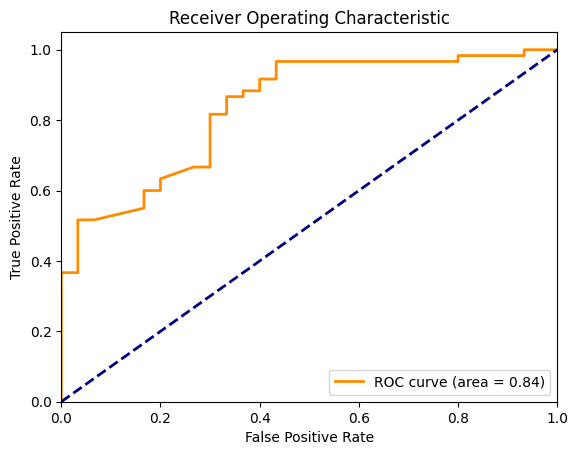

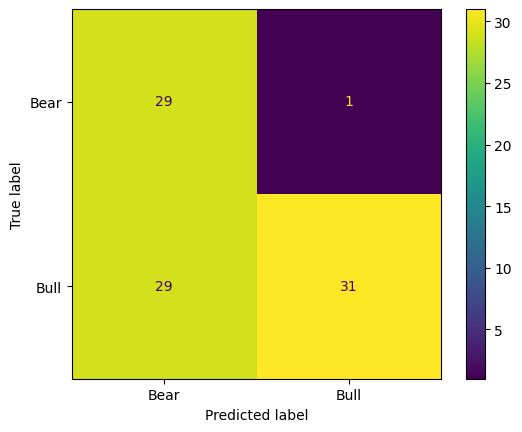

90-Day: Recall: 0.52
90-Day: ROC AUC: 0.84
90-Day: Precision: 0.97


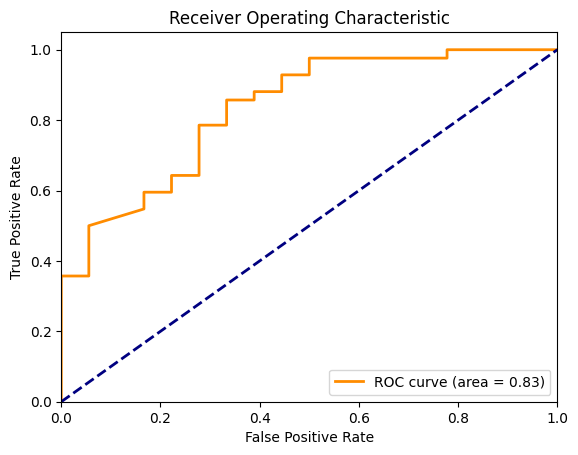

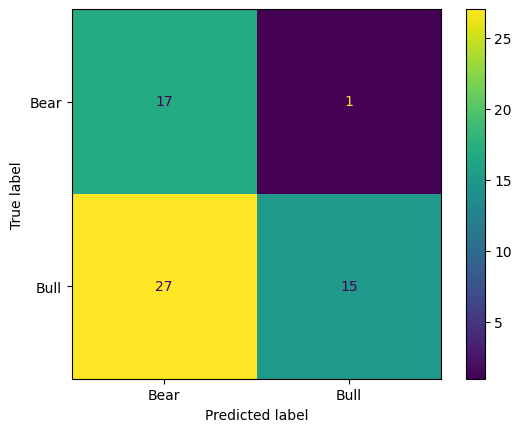

60-Day: Recall: 0.36
60-Day: ROC AUC: 0.83
60-Day: Precision: 0.94


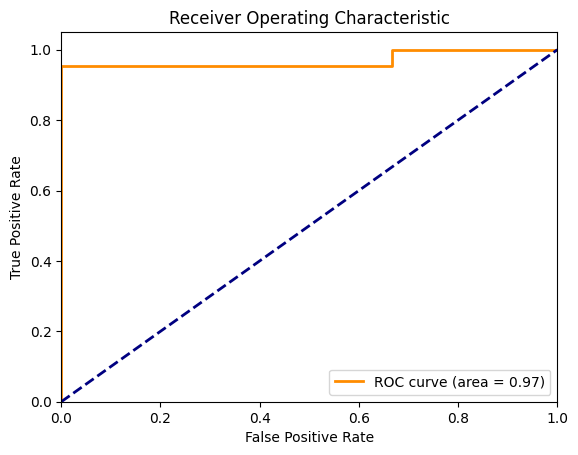

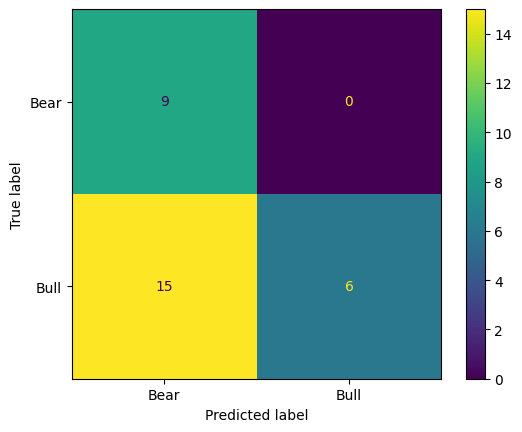

30-Day: Recall: 0.29
30-Day: ROC AUC: 0.97
30-Day: Precision: 1.00


In [329]:
y_pred = best_model_90.predict_proba(X_test_validation)[:, 1]
fpr, tpr, _ = roc_curve(Y_test_validation, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

y_pred = np.where(y_pred > hyperparameters['alpha'], 1, 0)
precision = precision_score(Y_test_validation, y_pred)

# plot the confusion matrix
cm = confusion_matrix(Y_test_validation, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bear', 'Bull'])
disp.plot()
plt.show()


print(f'90-Day: Recall: {recall_score(Y_test_validation, y_pred):.2f}')
print(f'90-Day: ROC AUC: {roc_auc:.2f}')
print(f'90-Day: Precision: {precision:.2f}')

# 60 day

y_pred_60 = best_model_60.predict_proba(X_test_validation_60)[:, 1]
fpr, tpr, _ = roc_curve(Y_test_validation_60, y_pred_60)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

y_pred_60 = np.where(y_pred_60 > hyperparameters_60['alpha'], 1, 0)
precision = precision_score(Y_test_validation_60, y_pred_60)

# plot the confusion matrix
cm = confusion_matrix(Y_test_validation_60, y_pred_60)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bear', 'Bull'])
disp.plot()
plt.show()

print(f'60-Day: Recall: {recall_score(Y_test_validation_60, y_pred_60):.2f}')
print(f'60-Day: ROC AUC: {roc_auc:.2f}')
print(f'60-Day: Precision: {precision:.2f}')

# 30 day

y_pred_30 = best_model_30.predict_proba(X_test_validation_30)[:, 1]
fpr, tpr, _ = roc_curve(Y_test_validation_30, y_pred_30)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

y_pred_30 = np.where(y_pred_30 > hyperparameters_30['alpha'], 1, 0)
precision = precision_score(Y_test_validation_30, y_pred_30)

# plot the confusion matrix
cm = confusion_matrix(Y_test_validation_30, y_pred_30)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bear', 'Bull'])
disp.plot()

plt.show()

print(f'30-Day: Recall: {recall_score(Y_test_validation_30, y_pred_30):.2f}')
print(f'30-Day: ROC AUC: {roc_auc:.2f}')
print(f'30-Day: Precision: {precision:.2f}')


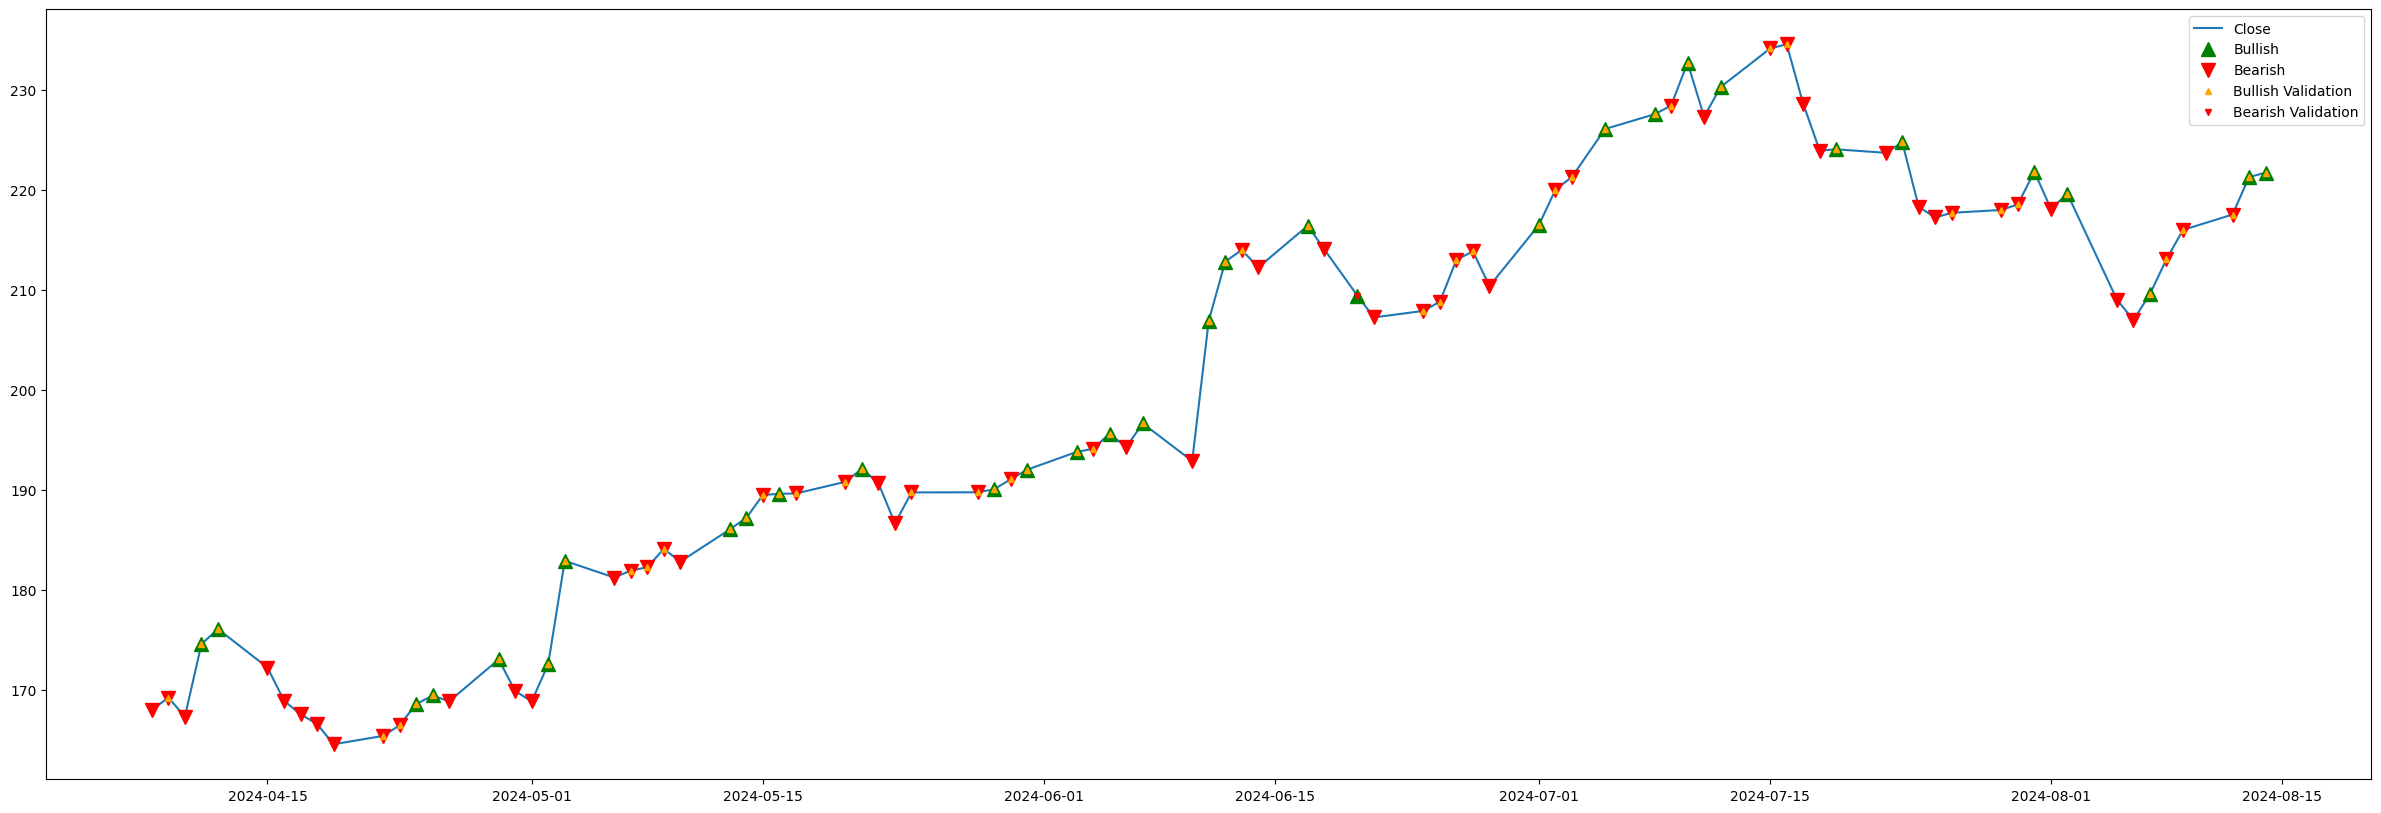

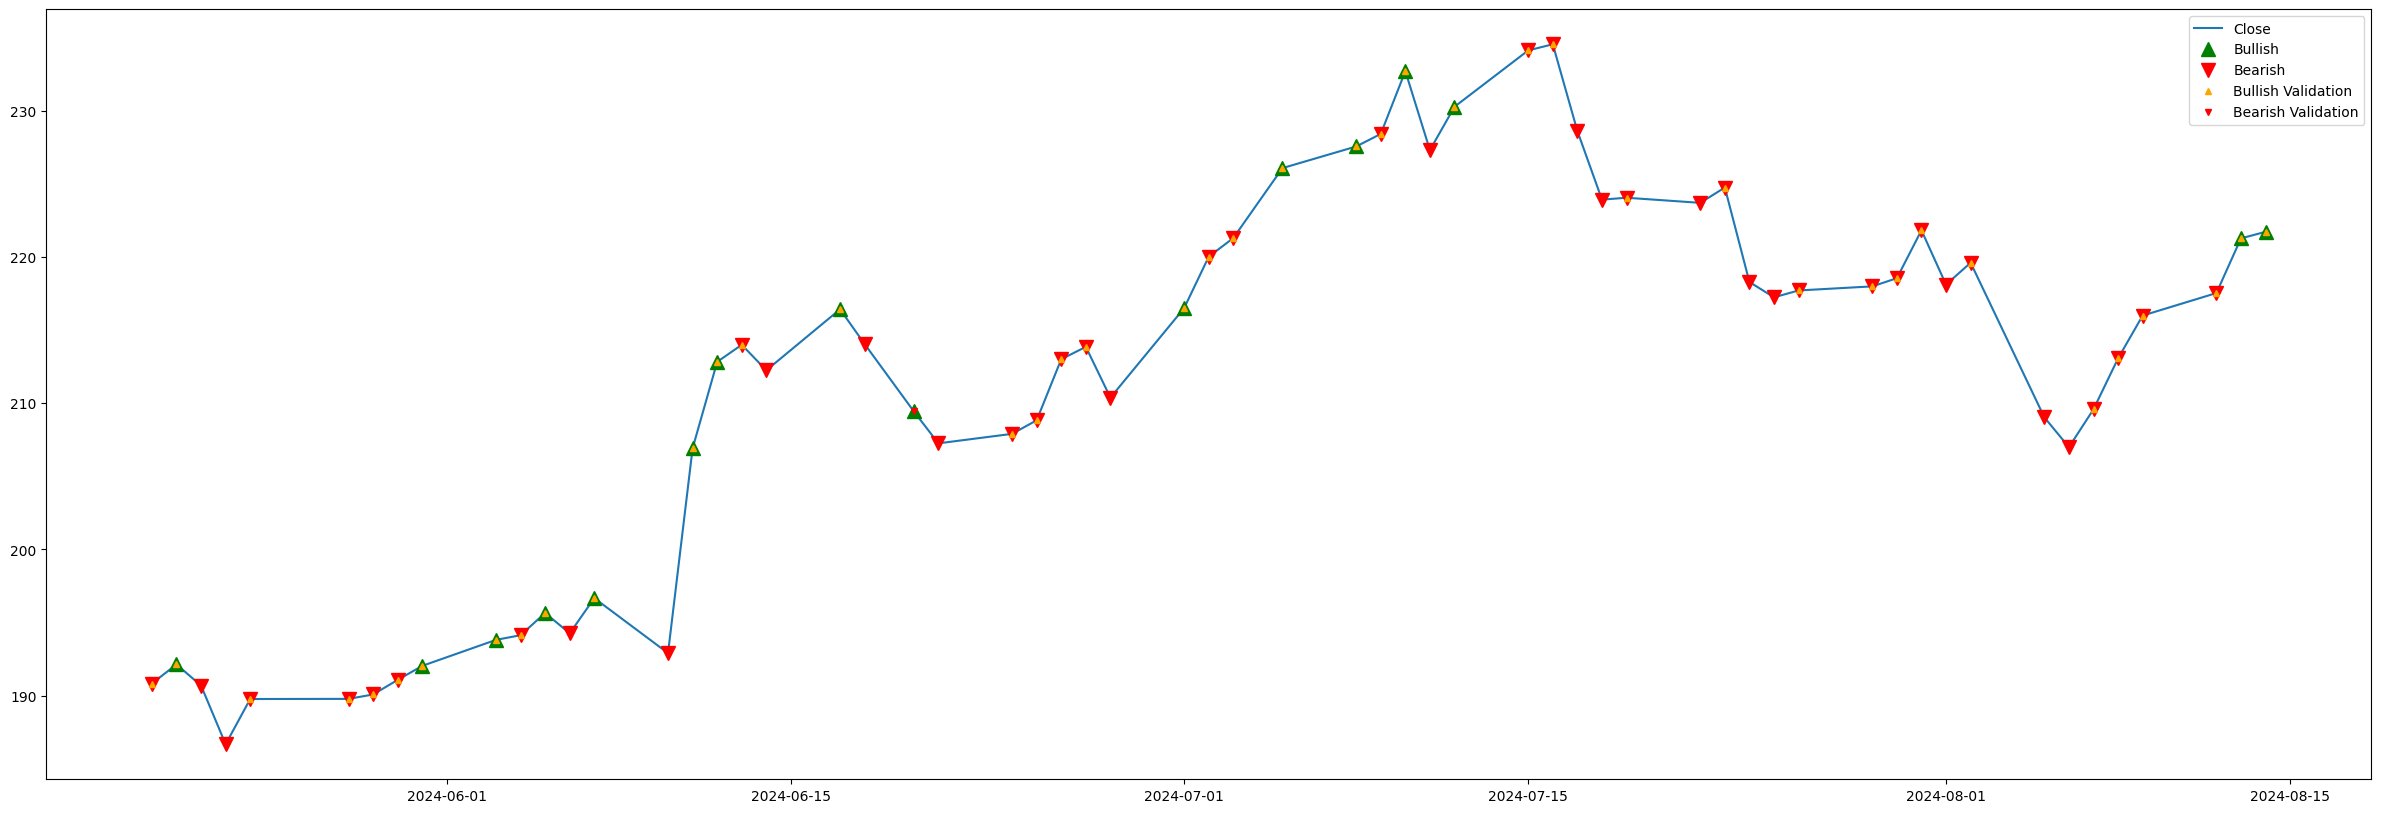

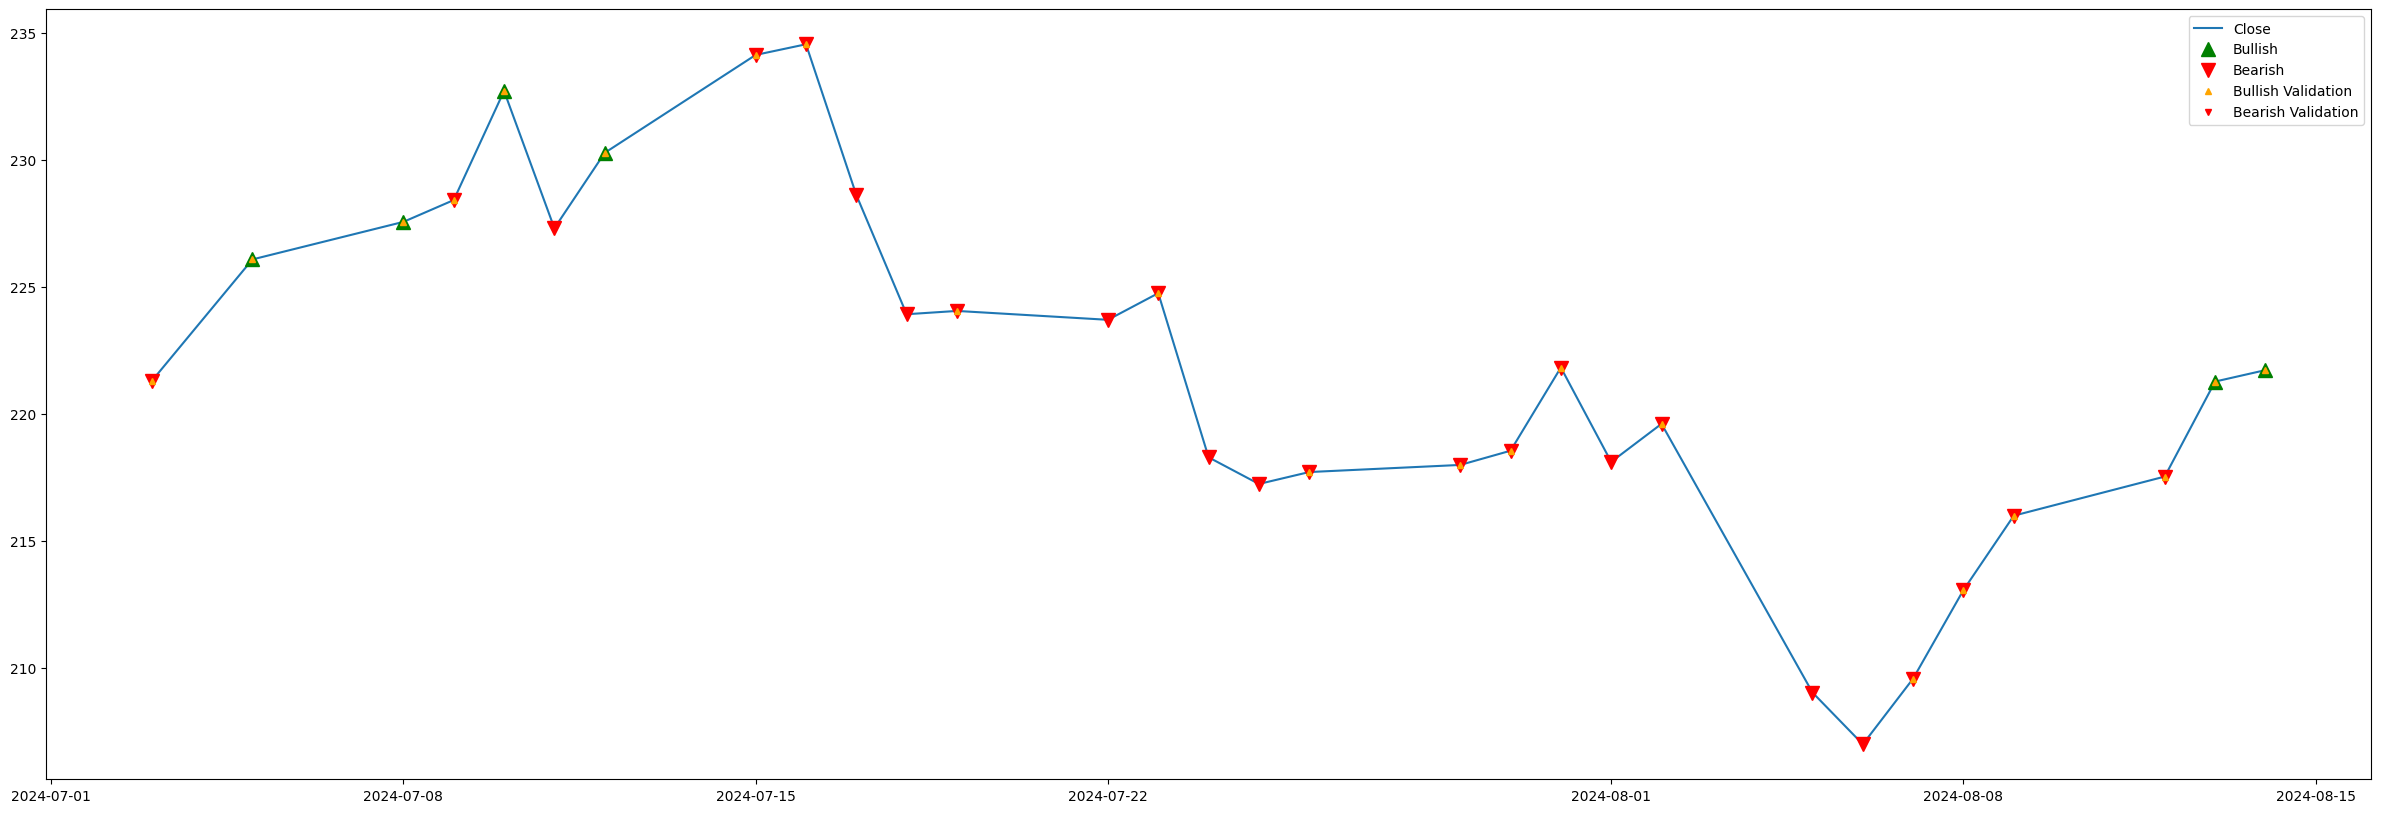

In [331]:
# plot the y_pred as markers on the close price
plt.figure(figsize=(30, 10))
plt.plot(data_clean['Close'].iloc[-90:], label='Close')
plt.plot(data_clean['Close'].iloc[-90:][y_pred == 1], 'g^', markersize=10, label='Bullish')
plt.plot(data_clean['Close'].iloc[-90:][y_pred == 0], 'rv', markersize=10, label='Bearish')
plt.plot(data_clean['Close'].iloc[-90:][Y_test_validation == 1], '^', markersize=5, label='Bullish Validation', color='orange')
plt.plot(data_clean['Close'].iloc[-90:][Y_test_validation == 0], 'rv', markersize=5, label='Bearish Validation')
plt.legend()
plt.show()

# plot the y_pred as markers on the close price
plt.figure(figsize=(30, 10))
plt.plot(data_clean['Close'].iloc[-60:], label='Close')
plt.plot(data_clean['Close'].iloc[-60:][y_pred_60 == 1], 'g^', markersize=10, label='Bullish')
plt.plot(data_clean['Close'].iloc[-60:][y_pred_60 == 0], 'rv', markersize=10, label='Bearish')
plt.plot(data_clean['Close'].iloc[-60:][Y_test_validation_60 == 1], '^', markersize=5, label='Bullish Validation', color='orange')
plt.plot(data_clean['Close'].iloc[-60:][Y_test_validation_60 == 0], 'rv', markersize=5, label='Bearish Validation')
plt.legend()
plt.show()

# plot the y_pred as markers on the close price
plt.figure(figsize=(30, 10))
plt.plot(data_clean['Close'].iloc[-30:], label='Close')
plt.plot(data_clean['Close'].iloc[-30:][y_pred_30 == 1], 'g^', markersize=10, label='Bullish')
plt.plot(data_clean['Close'].iloc[-30:][y_pred_30 == 0], 'rv', markersize=10, label='Bearish')
plt.plot(data_clean['Close'].iloc[-30:][Y_test_validation_30 == 1], '^', markersize=5, label='Bullish Validation', color='orange')
plt.plot(data_clean['Close'].iloc[-30:][Y_test_validation_30 == 0], 'rv', markersize=5, label='Bearish Validation')
plt.legend()
plt.show()